## Neural Style Transfer with Tensorflow

In [1]:
#importing the required framework
import tensorflow as tf
tf.enable_eager_execution()
#enabling the eager execution mode of tensorflow

#we will use VGG19 model for neural style transfer
from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
#instantiate the model that is loaded
model =VGG19(
    include_top=False,
    weights='imagenet'
)
model.trainable=False
#we will use pre-trained weights of model that is train on image net
#setting include top as False we don't need to include the top layers at all
#we don't want the model to train, we just want to use it only
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
#importing some useful libraries and helper function
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
#to load our images and to convert them to array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
#preprocessing helper function, transforms input image array into the format that model expects
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#preprocessing the input images
def load_and_process_image(image_path):
    img=load_img(image_path)
    #to read the image
    img=img_to_array(img)
    #to convert the image into array
    img=preprocess_input(img)
    #preprocess the image
    img=np.expand_dims(img,axis=0)
    #expanding the dimension since model take 4 dimension image as input
    return img

In [6]:
#function to de-process the images and display them
#since after applying neural style transfer, images will be in the fomr of array so we have to deprocess them
def deprocess(x):
    x[:,:,0]+=103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68
    x=x[:,:,::-1]
    #to invert the order of the channels
    
    x=np.clip(x,0,255).astype('uint8')
    #since maximumg rgb can't cross 255
    return x

#function for displaying the images
def display_image(image):
    if len(image.shape)==4:
        img=np.squeeze(image,axis=0)
        #to get back the preprocessed image as three dimensional array
    img=deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

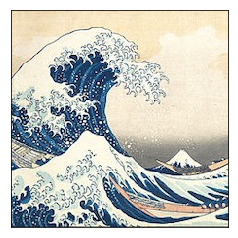

In [7]:
img = load_and_process_image('style.jpg')
display_image(img)
#let's see the style image

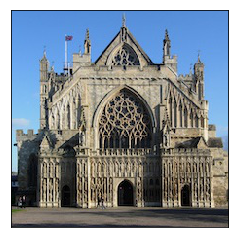

In [8]:
img = load_and_process_image('content.jpg')
display_image(img)
#lets see the content image

In [9]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]
#for stylistic feature layers we will be using are style_layers

content_layer = 'block5_conv2'
#picking the content layer that will best detect the edges

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)
#model will have the same input as the VGG19
#model will have the output as the content layer that we have choosed
#else layers will be same as VGG19

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]
#building the style model with the input same as VGG19
#but ouput will be different style layers

In [10]:
#computing the content cost with sterlized image and the generated image
def content_cost(content,generated):
    a_C=content_model(content)
    a_G=content_model(generated)
    #calculating the activations of both the images
    cost=tf.reduce_mean(tf.square(a_C-a_G))
    #to check how good the content and generated images detection are at the content layer
    return cost

In [11]:
#gram matrix gives fundamental correlation between the shapes
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    #reshaping the image array
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)
    #dividing by the total number of features
#to match feature distribution between two images

In [12]:
#style cost would be the weighted sum of each model style cost
lam = 1. / len(style_models)
#since cost will be weigthed

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        #activations for the style models
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        #gram matrix for the style models over generated images and style images
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
        #this gives the total style cost
    
    return J_style

In [13]:
#setting up the training loop basically the optimization loop
import time
#used to store some intermediate resulted images
generated_images = []

def training_loop(content_path, style_path, iterations = 20, alpha = 10., beta = 20.):
    # aplha is multiplied by the content cost
    # beta is multiplied by the style cost
    # since overall cost is the weigthed cost of both the cost 
    content = load_and_process_image(content_path)
    #loading and processing the content image
    style = load_and_process_image(style_path)
    #loading and processing the style image
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    #since we will be using eager mode
    #values will be derived from the content image
    
    opt = tf.train.AdamOptimizer(learning_rate = 7.)
    #using Adam optimizer
    
    best_cost = 1e12+0.1
    #defining the best cost and images since we will store the best image and cost
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            #automated differentiation come in place
            J_content = content_cost(content, generated)
            #calculated the content cost
            J_style = style_cost(style, generated)
            #calculated the style cost
            J_total = alpha * J_content + beta * J_style
            #overall cost
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        #calculating the gradient and applying the optimizer
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [14]:
best_image=training_loop('content.jpg','style.jpg')
#running the training loop

Cost at 0: 13733912576.0. Time elapsed: 31.091968774795532
Cost at 2: 5336516096.0. Time elapsed: 98.13433241844177
Cost at 4: 3317655296.0. Time elapsed: 162.32216429710388
Cost at 6: 2499503616.0. Time elapsed: 225.5589120388031
Cost at 8: 2034322048.0. Time elapsed: 286.9791567325592
Cost at 10: 1640854528.0. Time elapsed: 348.87801909446716
Cost at 12: 1319436416.0. Time elapsed: 411.8839292526245
Cost at 14: 1099801216.0. Time elapsed: 479.2192187309265
Cost at 16: 954208064.0. Time elapsed: 543.6855857372284
Cost at 18: 835950144.0. Time elapsed: 612.9896631240845


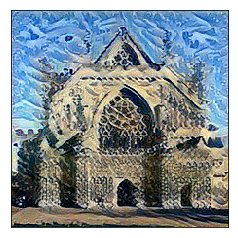

In [15]:
display_image(best_image)
#to see the best image we have stored